# EXO 2

In [1]:
import numpy as np
import pylab
import healpy as hp
import pysm3 
import pysm3.units as u
import matplotlib.pyplot as py
import cmbdb as cmb



In [2]:
from fgbuster.separation_recipes import harmonic_comp_sep,harmonic_comp_sep_beam,basic_comp_sep,_A_evaluator,_A_evaluator_beam,_r_to_c_alms
from fgbuster.mixingmatrix import MixingMatrix

In [3]:
from fgbuster import observation_helpers as oh

In [4]:
from fgbuster.cosmology import _get_Cl_noise,xForecast, harmonic_xForecast,harmonic_noise_cov

In [5]:
from fgbuster.component_model import CMB, Dust, Synchrotron

#### $C_{\ell}$ to $D_{\ell}=\frac{\ell(\ell+1)}{\pi}\times C_{\ell}$

In [6]:
def D_ell(C_ell):
    n_ell = len(C_ell)
    D_ell = np.zeros(n_ell)
    for i in range(n_ell):
        D_ell[i] = i*(i+1)*C_ell[i]/np.pi
    return(D_ell)

# Simulating Sky

In [7]:
NSIDE = 64
lmax = 3*NSIDE-1
print(lmax)
# sky_CMB = get_sky(NSIDE,'c1')
sky_d0s0 = oh.get_sky(NSIDE, 'd0s0') 
instrument = oh.get_instrument('LiteBIRD')
# freq_maps_CMB = get_observation(instrument, sky_CMB)
freq_maps_d0s0 = oh.get_observation(instrument,sky_d0s0)
num_freq,ncomp,npix = freq_maps_d0s0.shape



191


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [8]:
cl_CMB_th = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_lensed_scalar.fits")
print(cl_CMB_th.shape)

cl_CMB_crop_th = cl_CMB_th[:,:lmax+1]
print(cl_CMB_crop_th.shape)

(4, 4001)
(4, 192)


In [9]:
np.random.seed(0)
map_CMB = hp.synfast(cl_CMB_th,nside=NSIDE,new = True)

# hp.mollview(map_CMB[0])


print(map_CMB.shape)
# # hp.mollview(map_CMB[0], title='Input CMB', sub=(1,3,1))
# hp.mollview(map_CMB[1], title='$Q_{CMB,in}$', norm='hist', sub=(1,3,2))
# hp.mollview(map_CMB [2], title='$U_{CMB,in}$', norm='hist', sub=(1,3,3))



(3, 49152)


In [10]:
alm_CMB_th = hp.map2alm(map_CMB,lmax)

In [11]:
print(alm_CMB_th.shape)
alm_CMB_th = alm_CMB_th[1:3,:]
print(alm_CMB_th.shape)


(3, 18528)
(2, 18528)


In [12]:
cl_CMB6 = hp.anafast(map_CMB,lmax=lmax,alm = False)
cl_CMB = cl_CMB6[:4]
print(cl_CMB.shape)

(4, 192)


In [13]:
# map_CMB_QU = np.zeros((2,npix),dtype=complex)
# map_CMB_QU[0] = map_CMB[1]  # Q
# map_CMB_QU[1] = map_CMB[2]  # Q
# print(map_CMB_QU.shape)

In [14]:
freq_maps_simple_noiseless = np.array([np.add(map_CMB,map_d0s0) for map_d0s0 in freq_maps_d0s0])
np.random.seed(0)

freq_map_noise = oh.get_noise_realization(NSIDE,instrument#,unit = 'uK_CMB'
                                       )

amin2rad = np.pi/(60.*180.)

In [15]:
fwhm = instrument.fwhm*amin2rad
freq = instrument.frequency
fwhm_common = 80*amin2rad


In [16]:
alms = hp.map2alm(map_CMB)
print(alms.shape)

(3, 18528)


In [17]:
ell = hp.Alm.getlm(lmax, np.arange(alms.shape[-1]))[0]
ell = np.stack((ell, ell), axis=-1).reshape(-1) 

In [18]:
beam_array = np.array([hp.gauss_beam(f,lmax, pol=True) for f in instrument.fwhm*np.pi/(60.*180.)])
# beam_array = beam_array[:,:,1:3] ## Only keeping polarization so E & B modes 
num_freq, num_l, num_stokes = beam_array.shape
beam_array_lm1 = beam_array[:,ell,:]
beam_array_lm2 = np.array([beam_array[:,l,:] for l in ell])

In [19]:
beam_array_lm1 = np.transpose(beam_array_lm1,(1,0,2))

In [20]:
print(beam_array_lm2.shape)

(37056, 15, 4)


In [21]:
diff_beam = beam_array_lm1-beam_array_lm2
# print(diff_beam==np.zeros(diff_beam.shape))
print(beam_array_lm1==beam_array_lm2)

[[[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ...
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ...
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ...
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 ...

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ...
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ...
  [ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]]

 [[ True  True  True  True]
  [ True  True  True  True]
  [ True  True  True  True]
  ...
  [ True  True  True  Tr

In [22]:
# beam_diag_lm1 = np.array([[np.diag(beam_array_lm1[:,i,j]) for i in range(0,np.size(ell))]for j in range(0,num_stokes)])
# beam_diag_lm1 = np.transpose(beam_diag_lm1, (1, 0, 2, 3))

In [23]:
beam_diag_lm2 = np.array([[np.diag(beam_array_lm2[i,:,j]) for i in range(0,np.size(ell))]for j in range(0,num_stokes)])
beam_diag_lm2 = np.transpose(beam_diag_lm2, (1, 0, 2, 3))
# print(r'beam_array[0,ell,:] has shape' + str(beam_array_lm1.shape))
# print(r'np.array([beam_array[:,l,:] for l in ell] has shape' + str(beam_array_lm2.shape))

# print(beam_diag_lm2.shape)
# diff_beam = beam_array_lm1-beam_array_lm2
# print(diff_beam)
print(beam_diag_lm2.shape)

(37056, 4, 15, 15)


## Beam (check with hp.smoothing)

In [24]:
beam_array = np.array([hp.gauss_beam(f,lmax = lmax, pol=True) for f in fwhm])
print(beam_array.shape)
inv_beam_arr = 1/beam_array
fwhm_common = 80*amin2rad
beam_common = hp.gauss_beam(fwhm_common,lmax = lmax, pol = True)
b_c = np.array([beam_common*beam_inv for beam_inv in inv_beam_arr])
print(b_c.shape)
print(map_CMB.shape,beam_common.shape)

(15, 192, 4)
(15, 192, 4)
(3, 49152) (192, 4)


In [25]:
# map_CMB_smooth = np.array([hp.smoothing(map_CMB[j,:],beam_window=beam_common[:,j]) for j in range(0,ncomp)])
# print(map_CMB_smooth.shape)


In [26]:
# map_CMB_smooth_QU = np.zeros((2,npix))
# map_CMB_smooth_QU[0]=map_CMB_smooth[1]   
# map_CMB_smooth_QU[1]=map_CMB_smooth[2]
# print(map_CMB_smooth_QU.shape)
# print(freq_maps_simple_noiseless[0,0].shape)
# print(beam_array[0,0].shape)

## $(B \ast As)_p$

In [27]:
BAS_p_nl_smooth = np.array([np.array([hp.smoothing(freq_maps_simple_noiseless[i,j],beam_window=beam_array[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])
print(BAS_p_nl_smooth.shape)

(15, 3, 49152)


## $(B^{\nu}  \ast A^{\nu} s+n)_p$

In [28]:
BAS_p = np.add(BAS_p_nl_smooth,freq_map_noise)

In [29]:
print(BAS_p.shape)

(15, 3, 49152)


## $\frac{1}{B^{\nu}}(B^{\nu}  \ast A^{\nu} s+n)_p$
## $\frac{B^{c}}{B^{\nu}}(B^{\nu}  \ast A^{\nu} s+n)_p$

In [30]:
# AS_p_inv = np.array([np.array([hp.smoothing(BAS_p[i,j],beam_window=inv_beam_arr[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

AS_p_ren = np.array([np.array([hp.smoothing(BAS_p[i,j],beam_window=b_c[i,:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])

#### $As+n$

In [31]:
As_p = freq_map_noise+freq_maps_simple_noiseless
print(As_p.shape)

(15, 3, 49152)


In [32]:
print(beam_common.shape)

(192, 4)


#### $B^c As+n$

In [33]:
BcAs_p =  np.array([np.array([hp.smoothing(freq_maps_simple_noiseless[i,j],beam_window=beam_common[:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])


In [34]:
print(BcAs_p.shape)

(15, 3, 49152)


### Deconvolved and renormalized only in $(Q,U)$

In [35]:
# AS1_QU_p = np.zeros((num_freq,2,npix))
# AS1_QU_p[:,0,:]=AS_p_inv[:,1,:]
# AS1_QU_p[:,1,:]=AS_p_inv[:,2,:]
# print(AS1_QU_p.shape)
# AS2_QU_p = np.zeros((num_freq,2,npix))
# AS2_QU_p[:,0,:]=AS_p_ren[:,1,:]
# AS2_QU_p[:,1,:]=AS_p_ren[:,2,:]
# print(AS2_QU_p.shape)

## Component separation

In [36]:
components = [CMB(), Dust(353.), Synchrotron(23.)]
# The starting point of the fit is the ax1sm default value, so let's shift it
components[1].defaults = [1.54, 20.]
components[2].defaults = [-3.0]

### Mixing matrix evaluator

In [37]:
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)
i_cmb = A.components.index('CMB')

In [38]:
# print(freq_maps_simple_noiseless.shape)
# print(freq_map_noise.shape)

#### Test of harmonic comp sep with beamless maps

In [39]:
# ASn_p = freq_maps_simple_noiseless+freq_map_noise
# print(ASn_p.shape)
# result_no_beam= harmonic_comp_sep(components, instrument, ASn_p,NSIDE,lmax # verbose output                        
#                        )

#### Test of harmonic comp sep with beamed maps

In [40]:
instrument_common = oh.get_instrument('LiteBIRD')
instrument_common.fwhm = [fwhm_common for fwhm in instrument_common.fwhm]
print(instrument_common.fwhm)

0     0.023271
1     0.023271
2     0.023271
3     0.023271
4     0.023271
5     0.023271
6     0.023271
7     0.023271
8     0.023271
9     0.023271
10    0.023271
11    0.023271
12    0.023271
13    0.023271
14    0.023271
Name: fwhm, dtype: float64


In [41]:
instrument_null = oh.get_instrument('LiteBIRD')
instrument_null.fwhm = [0 for fwhm in instrument_null.fwhm]
print(instrument_null.fwhm)

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
Name: fwhm, dtype: int64


In [42]:

# result_no_beam_beam= harmonic_comp_sep_beam(components, instrument2, ASn_p,NSIDE,lmax # verbose output                        
#                        )

###  Retrieving estimated parameters

In [43]:
# inputs = [sky_d0s0.components[0].mbb_index,
#           sky_d0s0.components[0].mbb_temperature.value,
#           sky_d0s0.components[1].pl_index]

# print('No beam : Harmonic component separation')
# print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))

# for param, val, ref in zip(result_no_beam.params, result_no_beam.x, inputs):
#     print("%-20s\t%f\t%f" % (param, val, ref))


# print('No beam : Harmonic component separation with beam')
# print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))

# for param, val, ref in zip(result_no_beam_beam.params, result_no_beam_beam.x, inputs):
#     print("%-20s\t%f\t%f" % (param, val, ref))

### Harmonic comp sep with beam and renormalized maps

In [44]:

# result_harmo_beam_ren= harmonic_comp_sep(components, instrument, AS_p_ren,NSIDE,lmax # verbose output                        
#                        )
# inputs = [sky_d0s0.components[0].mbb_index,
#           sky_d0s0.components[0].mbb_temperature.value,
#           sky_d0s0.components[1].pl_index]

# print('Harmonic component separation')
# print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))

# for param, val, ref in zip(result_harmo_beam_ren.params, result_harmo_beam_ren.x, inputs):
#     print("%-20s\t%f\t%f" % (param, val, ref))




# Harmonic component separation with beam, input are beamed maps

In [45]:

result_no_beam= harmonic_comp_sep(components, instrument, AS_p_ren,NSIDE,lmax # verbose output                        
                       )

Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [46]:



result_no_beam_BAS= harmonic_comp_sep(components, instrument, BAS_p,NSIDE,lmax # verbose output                        
                       )




Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future versi

In [47]:
result_beam= harmonic_comp_sep_beam(components, instrument, BAS_p,NSIDE,lmax # verbose output                        
                       )
print(result_beam.params)

Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:198: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]


['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']


/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [48]:
print(result_beam.s.shape)
A_beam = A_ev(result_beam.x)
A_no_beam = A_ev(result_no_beam.x)

print(A_beam.shape)
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]
print('Harmonic & beam component separation')

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))

for param, val, ref in zip(result_beam.params, result_beam.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_no_beam.params, result_no_beam.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

(3, 2, 18528)
(15, 3)
Harmonic & beam component separation
                    	Estimated	Input
Dust.beta_d         	1.544822	1.540000
Dust.temp           	19.852110	20.000000
Synchrotron.beta_pl 	-3.026368	-3.000000
                    	Estimated	Input
Dust.beta_d         	1.543251	1.540000
Dust.temp           	19.902010	20.000000
Synchrotron.beta_pl 	-3.016364	-3.000000


In [49]:

A_no_beam_BAS = A_ev(result_no_beam_BAS.x)

print(A_no_beam_BAS.shape)
inputs = [sky_d0s0.components[0].mbb_index,
          sky_d0s0.components[0].mbb_temperature.value,
          sky_d0s0.components[1].pl_index]
print('Harmonic & beam component separation')



print("%-20s\t%s\t%s" % ('', 'Estimated', 'Input'))
for param, val, ref in zip(result_no_beam_BAS.params, result_no_beam_BAS.x, inputs):
    print("%-20s\t%f\t%f" % (param, val, ref))

(15, 3)
Harmonic & beam component separation
                    	Estimated	Input
Dust.beta_d         	1.539124	1.540000
Dust.temp           	20.146111	20.000000
Synchrotron.beta_pl 	-3.004724	-3.000000


### Get noise

In [50]:
def _get_Cl_noise_nofwhm(instrument,beam, A, lmax):
    nl = (beam / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2
    AtNA = np.einsum('fi, fl, fj -> lij', A, nl, A)
    inv_AtNA = np.linalg.inv(AtNA)
    return inv_AtNA.swapaxes(-3, -1)

In [51]:
beam_null = np.ones((len(instrument.frequency), lmax+1))


In [52]:

# cl_noise_beam =_get_Cl_noise_nofwhm(instrument=instrument,beam = inv_beam_arr[:,:,0] ,A = A_beam,lmax=lmax)[i_cmb, i_cmb, :]
# cl_noise_no_beam =_get_Cl_noise_nofwhm(instrument=instrument,beam = inv_beam_arr[:,:,0] ,A = A_beam,lmax=lmax)[i_cmb, i_cmb, :]


cl_noise_beam =_get_Cl_noise_nofwhm(instrument,beam_null, A_beam,lmax)[i_cmb, i_cmb, :]

cl_noise_no_beam =_get_Cl_noise_nofwhm(instrument,beam_null, A_no_beam,lmax)[i_cmb, i_cmb, :]




/tmp/ipykernel_2428/1937513622.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (beam / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [53]:
print(cl_noise_beam.shape)

(192,)


In [54]:
cl_noise_no_beam_BAS =_get_Cl_noise(instrument,A_no_beam_BAS,lmax)[i_cmb, i_cmb, :]


/home/julientang2001/fgbuster/fgbuster/cosmology.py:742: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (bl / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


### Harmonic component separation returns Component amplitude alms

In [55]:
result_beam_alm_r = result_beam.s
result_beam_alm = _r_to_c_alms(result_beam_alm_r)
result_beam_alm.shape
# best_fit_maps_beam = np.array([hp.alm2map(result_beam_alm[:,i,:],NSIDE,lmax) for i in range(2)])
# best_fit_maps_beam = np.transpose(best_fit_maps_beam,(1,0,2))
# print(best_fit_maps_beam.shape)

(3, 2, 18528)

In [56]:
# print(result_beam_alm_r.shape)
# print(result_beam_alm_r.dtype)
# print(result_beam_alm.dtype)
# print(result_beam_alm_r-result_beam_alm)
# print(result_beam.fsky)

In [57]:
result_no_beam_alm_r = result_no_beam.s
result_no_beam_alm = _r_to_c_alms(result_no_beam_alm_r)
# result_no_beam_alm.shape
# best_fit_maps_no_beam = np.array([hp.alm2map(result_no_beam_alm[:,i,:],NSIDE,lmax) for i in range(2)])
# best_fit_maps_no_beam = np.transpose(best_fit_maps_no_beam,(1,0,2))
# print(best_fit_maps_no_beam.shape)

In [58]:
result_no_beam_BAS_alm_r = result_no_beam_BAS.s
result_no_beam_BAS_alm = _r_to_c_alms(result_no_beam_BAS_alm_r)

In [59]:
# hp.mollview(best_fit_maps_beam[0,1], title='CMB', sub=(1,3,1))
# hp.mollview(best_fit_maps_beam[1,1], title='Dust', norm='hist', sub=(1,3,2))
# hp.mollview(best_fit_maps_beam[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))


# hp.mollview(best_fit_maps_no_beam[0,1], title='CMB', sub=(1,3,1))
# hp.mollview(best_fit_maps_no_beam[1,1], title='Dust', norm='hist', sub=(1,3,2))
# hp.mollview(best_fit_maps_no_beam[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))
# map_diff_bnb = best_fit_maps_beam-best_fit_maps_no_beam
# hp.mollview(map_diff_bnb[0,1], title='CMB', sub=(1,3,1))
# hp.mollview(map_diff_bnb[1,1], title='Dust', norm='hist', sub=(1,3,2))
# hp.mollview(map_diff_bnb[2,1], title='Synchrotron', norm='hist', sub=(1,3,3))

# Residuals

In [60]:
# res_CMB_Q_b = np.subtract(best_fit_maps_beam[0,0], map_CMB_QU[0])#noisy
# res_CMB_U_b = np.subtract(best_fit_maps_beam[0,1], map_CMB_QU[1])

# print(res_CMB_Q_b.shape,res_CMB_U_b.shape)
# res_CMB_Q_nb = np.subtract(best_fit_maps_no_beam[0,0], map_CMB_QU[0])#noisy
# res_CMB_U_nb = np.subtract(best_fit_maps_no_beam[0,1], map_CMB_QU[1])

# print(res_CMB_Q_nb.shape,res_CMB_U_nb.shape)
# res_CMB_b= np.zeros((3,npix),dtype=complex)
# res_CMB_b[1] = res_CMB_Q_b
# res_CMB_b[2] = res_CMB_U_b
# print(res_CMB_b.shape)
# res_CMB_nb= np.zeros((3,npix),dtype=complex)
# res_CMB_nb[1] = res_CMB_Q_nb
# res_CMB_nb[2] = res_CMB_U_nb
# print(res_CMB_nb.shape)

#### Computing $C_{\ell}^{res}$

In [61]:
# Cl1_res_CMB_b=hp.anafast(res_CMB_b,lmax = lmax,alm=False,pol=True)
# print(Cl1_res_CMB_b.shape)
# Cl1_res_CMB_nb=hp.anafast(res_CMB_nb,lmax = lmax,alm=False,pol=True)
# print(Cl1_res_CMB_nb.shape)

In [62]:
alm_resi_CMB_beam = result_beam_alm[0]-alm_CMB_th
alm_resi_CMB_no_beam = result_no_beam_alm[0]-alm_CMB_th
alm_resi_CMB_no_beam_BAS = result_no_beam_BAS_alm[0]-alm_CMB_th

print(alm_resi_CMB_beam.shape,alm_resi_CMB_no_beam.shape)

Cl_res_CMB_b=np.array([hp.alm2cl(alm) for alm in alm_resi_CMB_beam])
print(Cl_res_CMB_b.shape)
Cl_res_CMB_nb=np.array([hp.alm2cl(alm) for alm in alm_resi_CMB_no_beam])
print(Cl_res_CMB_nb.shape)
Cl_res_CMB_nb_BAS=np.array([hp.alm2cl(alm) for alm in alm_resi_CMB_no_beam_BAS])
print(Cl_res_CMB_nb_BAS.shape)
Cl_res_CMB_EE_b = Cl_res_CMB_b[0]
Cl_res_CMB_BB_b= Cl_res_CMB_b[1]
Cl_res_CMB_EE_nb = Cl_res_CMB_nb[0]
Cl_res_CMB_BB_nb= Cl_res_CMB_nb[1]
Cl_res_CMB_EE_nb_BAS = Cl_res_CMB_nb_BAS[0]
Cl_res_CMB_BB_nb_BAS= Cl_res_CMB_nb_BAS[1]
print(Cl_res_CMB_EE_b.shape)
print(Cl_res_CMB_BB_b.shape)

(2, 18528) (2, 18528)
(2, 192)
(2, 192)
(2, 192)
(192,)
(192,)


### Retrieved CMB Power spectrum

In [63]:
# ret_resul_b = np.zeros((3,npix),dtype=complex)
# ret_resul_b[1] = best_fit_maps_beam[0,0]
# ret_resul_b[2] = best_fit_maps_beam[0,1]
# print(ret_resul_b.shape)


# ret_resul_nb = np.zeros((3,npix),dtype=complex)
# ret_resul_nb[1] = best_fit_maps_no_beam[0,0]
# ret_resul_nb[2] = best_fit_maps_no_beam[0,1]
# print(ret_resul_nb.shape)
# Cl_ret_b = hp.anafast(ret_resul_b,alm = False,pol=True)
# print(Cl_ret_b.shape)
# Cl_ret_BB_b = Cl_ret_b[2]
# print(Cl_ret_BB_b.shape)

# Cl_ret_nb = hp.anafast(ret_resul_nb,alm = False,pol=True)
# print(Cl_ret_nb.shape)
# Cl_ret_BB_nb = Cl_ret_nb[2]
# print(Cl_ret_BB_nb.shape)


### Basic component separation

In [64]:
result_beam_ren = basic_comp_sep(components, instrument, AS_p_ren[:,1:3,:], # verbose output             
                               )
A_beam_ren = A_ev(result_beam_ren.x)

print(A_beam_ren.shape)

cl_noise_basic_ren = _get_Cl_noise_nofwhm(instrument,beam_null,A_beam_ren,lmax)[i_cmb,i_cmb,:]


(15, 3)


/tmp/ipykernel_2428/1937513622.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (beam / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [65]:
print(cl_noise_basic_ren.shape)

(192,)


In [66]:
result_basic = basic_comp_sep(components, instrument, As_p[:,1:3,:], # verbose output             
                               )
# A_beam_ren = A_ev(result_beam_ren.x)

# print(A_beam_ren.shape)



In [67]:
map_CMB_smooth = np.array([hp.smoothing(map_CMB[j,:],beam_window=beam_common[:,j]) for j in range(0,ncomp)])


In [68]:
print(map_CMB_smooth.shape)

(3, 49152)


In [69]:
CL_CMB_smooth = hp.anafast(map_CMB_smooth,lmax=lmax,alm=False, pol=True)

In [70]:
print(result_beam_ren.s.shape)

(3, 2, 49152)


In [71]:
res_CMB_Q_ren = np.subtract(result_beam_ren.s[0,0], map_CMB_smooth[1])
res_CMB_U_ren = np.subtract(result_beam_ren.s[0,1], map_CMB_smooth[2])
res_CMB_ren= np.zeros((3,npix),dtype=complex)
res_CMB_ren[1] = res_CMB_Q_ren
res_CMB_ren[2] = res_CMB_U_ren
print(res_CMB_ren.shape)

(3, 49152)


In [72]:
Cl_CMB_ren_res =hp.anafast(res_CMB_ren,lmax=lmax,alm=False,pol=True)


/home/julientang2001/.local/lib/python3.10/site-packages/healpy/sphtfunc.py:274: ComplexWarning: Casting complex values to real discards the imaginary part
  alms = _sphtools.map2alm(


In [73]:
print(Cl_CMB_ren_res.shape)

(6, 192)


In [74]:
res_ret_ren = np.zeros((3,npix),dtype=complex)
res_ret_ren[1] = result_beam_ren.s[0,0]
res_ret_ren[2] = result_beam_ren.s[0,1]

C_L_ret_ren = hp.anafast(res_ret_ren,alm = False,pol=True)
print(C_L_ret_ren.shape)
C_l_ret_ren_BB = C_L_ret_ren[2]
print(C_l_ret_ren_BB.shape)

(6, 192)
(192,)


# + Gravitational waves

In [75]:
cl_GW = hp.read_cl("/home/julientang2001/Stage3A/Cls_Planck2018_unlensed_scalar_and_tensor_r1.fits")
print(cl_GW.shape)
cl_GW_crop = cl_GW[:,:lmax+1]
print(cl_GW_crop.shape)

# map_CMB = hp.synfast(cl_GW,nside=NSIDE)

(4, 4101)
(4, 192)


In [76]:
cl_tot_th = np.add(0.001*cl_GW_crop,cl_CMB)

In [77]:
cl_CMB_BB_out_beam = result_beam.cl_out[0,1]
print(cl_CMB_BB_out_beam.shape)
cl_CMB_BB_out_no_beam = result_no_beam.cl_out[0,1]
print(cl_CMB_BB_out_no_beam.shape)
cl_CMB_BB_out_no_beam_BAS = result_no_beam_BAS.cl_out[0,1]
print(cl_CMB_BB_out_no_beam_BAS.shape)

(192,)
(192,)
(192,)


In [78]:
print(result_beam.s.shape)

(3, 2, 18528)


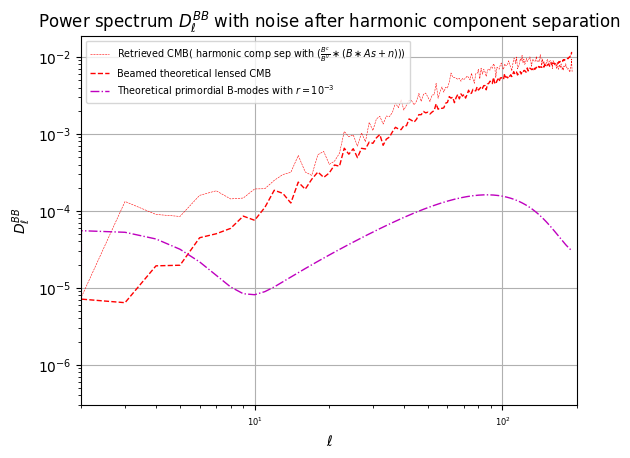

In [106]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*Cl_res_CMB_BB_nb,'r-.',linewidth =.4,label = r'Residual of harmonic comp sep with $(\frac{B^c}{B^{\nu}}\ast (B\ast As+n) )$')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB_BB_out_no_beam,'r--',linewidth = .4,label = r'Retrieved CMB( harmonic comp sep with $(\frac{B^c}{B^{\nu}}\ast (B\ast As+n) )$)')
ax1.plot(l_arr,D_ell(CL_CMB_smooth[2]+cl_noise_no_beam),'r--',linewidth =1,label = "Beamed theoretical lensed CMB")

# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*Cl_CMB_ren_res[2],'g-.',linewidth =.4,label = r'Residual of basic comp sep with $(\frac{B^c}{B^{\nu}}\ast (B\ast As+n) )$')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*C_l_ret_ren_BB,'g--',linewidth = .4,label = r'Retrieved CMB( basic comp sep with $(\frac{B^c}{B^{\nu}}\ast (B\ast As+n))$)')
# ax1.plot(l_arr,D_ell(CL_CMB_smooth[2]+cl_noise_basic_ren),'g--',linewidth =1,label = "Beamed theoretical lensed CMB")

# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*Cl_res_CMB_BB_nb_BAS,'r--',linewidth =.4,label = r'Residual of harmonic comp sep with $(B\ast As+n)$')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB_BB_out_no_beam_BAS,'g--',linewidth = .4,label = r'Retrieved CMB( harmonic comp sep with $(B\ast As+n)$)')

# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*Cl_res_CMB_BB_b,'b-.',linewidth =.4,label = r'Residual of harmonic comp sep beam with $(B\ast As+n)$')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB_BB_out_beam,'b--',linewidth =.4,label = r'Retrieved CMB( harmonic comp sep beam  with $(B\ast As+n))$')
# ax1.plot(l_arr,D_ell(CL_CMB_smooth[2]+cl_noise_beam),'b--',linewidth =1,label = "Beamed lensed CMB+associated noise")


# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_noise_beam,'r--',linewidth =1, label = 'Noise')
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB_crop_th[2],'b',linewidth =1,label = "Theoretical lensed CMB")
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*CL_CMB_smooth[2],'k--',linewidth =1,label = "Beamed theoretical lensed CMB")

py.title('Power spectrum $D_{\ell}^{BB}$ with noise after harmonic component separation')


ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

### Exercice 05/30

$As+n$ : compare basic_comp_sep, harmonic, hamornic_beam




In [80]:
print(As_p[:,1:3,:].shape)

(15, 2, 49152)


In [81]:
result_basic_comp = basic_comp_sep(components,instrument,As_p[:,1:3,:])
result_harmonic_basic = harmonic_comp_sep(components,instrument,As_p,NSIDE,lmax)


result_harmonic_beam = harmonic_comp_sep_beam(components,instrument_null,As_p,NSIDE,lmax)
map_resi_CMB_basicQU = result_basic_comp.s[0]-map_CMB[1:3]
alm_resi_CMB_harmonic_basic = result_harmonic_basic.s[0]-alm_CMB_th
alm_resi_CMB_harmonic_beam = result_harmonic_beam.s[0]-alm_CMB_th


Cl_res_CMB_harmo_basic=hp.alm2cl(alm_resi_CMB_harmonic_basic)
Cl_res_CMB_harmo_beam=hp.alm2cl(alm_resi_CMB_harmonic_beam)
print(Cl_res_CMB_harmo_beam.shape)

map_resi_CMB_basic = np.zeros((3,npix))
map_resi_CMB_basic[1:3] = map_resi_CMB_basicQU[0:2]
Cl_res_CMB_basic=hp.anafast(map_resi_CMB_basic,lmax=lmax,alm=False,pol=True)
print(Cl_res_CMB_basic.shape)

Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:198: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]


(3, 192)
(6, 192)


In [82]:
print(np.max(np.abs(alm_CMB_th)))
print(np.max(np.abs(result_harmonic_basic.s[0])))

print(map_resi_CMB_basicQU.shape)
print(alm_resi_CMB_harmonic_basic.shape,alm_resi_CMB_harmonic_beam.shape)


0.25027663658922744
0.25004747246163717
(2, 49152)
(2, 18528) (2, 18528)


#### Retrieved CMB

In [83]:
map_ret_CMB_basic = np.zeros((3,npix))
map_ret_CMB_basic[1:3] = result_basic_comp.s[0]
Cl_ret_CMB_basic = hp.anafast(map_ret_CMB_basic,lmax=lmax,alm=False,pol=True)

Cl_ret_CMB_harmo_basic=hp.alm2cl(result_harmonic_basic.s[0])
Cl_ret_CMB_harmo_beam=hp.alm2cl(result_harmonic_beam.s[0])
print(Cl_ret_CMB_harmo_beam.shape)


(3, 192)


#### Noise

In [84]:
A_basic = A_ev(result_basic_comp.x)

A_harmo_basic = A_ev(result_harmonic_basic.x)

A_harmo_beam = A_ev(result_harmonic_beam.x)



cl_noise_basic =_get_Cl_noise_nofwhm(instrument,beam_null,A_basic,lmax=lmax)[i_cmb, i_cmb, :]
cl_noise_harmonic =_get_Cl_noise_nofwhm(instrument,beam_null,A_harmo_basic,lmax=lmax)[i_cmb, i_cmb, :]
cl_noise_harmonic_beam =_get_Cl_noise_nofwhm(instrument,beam_null, A_harmo_beam,lmax=lmax)[i_cmb, i_cmb, :]


/tmp/ipykernel_2428/1937513622.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (beam / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


In [85]:
print(A_basic-A_harmo_basic)
print(np.where(A_basic-A_harmo_basic!=0))
print(np.where(cl_noise_basic!=cl_noise_harmonic))
print(np.where(cl_noise_harmonic_beam!=cl_noise_harmonic))
print(np.max(np.abs(cl_noise_basic-cl_noise_harmonic)))
print(cl_noise_basic.shape)

[[ 0.00000000e+00  1.89263555e-05  1.83194220e-03]
 [ 0.00000000e+00  2.33056630e-05  1.34396580e-03]
 [ 0.00000000e+00  2.74023012e-05  9.85920649e-04]
 [ 0.00000000e+00  3.04957459e-05  7.84860736e-04]
 [ 0.00000000e+00  3.41590710e-05  6.06983568e-04]
 [ 0.00000000e+00  3.79600031e-05  4.73375147e-04]
 [ 0.00000000e+00  4.15529232e-05  3.81146483e-04]
 [ 0.00000000e+00  4.73364398e-05  2.79471499e-04]
 [ 0.00000000e+00  5.31618520e-05  2.14377056e-04]
 [ 0.00000000e+00  5.94858743e-05  1.68925489e-04]
 [ 0.00000000e+00  6.49497091e-05  1.42136247e-04]
 [ 0.00000000e+00  6.78261454e-05  1.26921279e-04]
 [ 0.00000000e+00  5.93667530e-05  1.27565661e-04]
 [ 0.00000000e+00  1.85364206e-05  1.49131547e-04]
 [ 0.00000000e+00 -6.08955865e-05  2.07085171e-04]]
(array([ 0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,
        8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14]), array([1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2,
       1, 2, 1, 2, 1, 2,

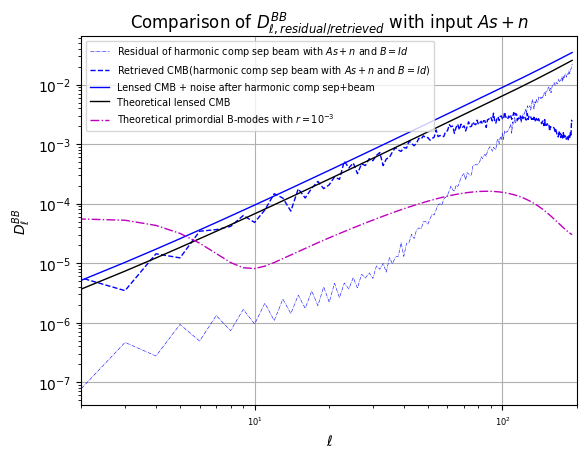

In [107]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)

# # ##Basic comp sep on As+n
# ax1.plot(l_arr,D_ell(Cl_res_CMB_basic[2]),'r-.',linewidth =.4,label = r'Residual of basic comp sep with $As+n$')
# ax1.plot(l_arr,D_ell(Cl_ret_CMB_basic[2]),'r--',linewidth = 1,label = r'Retrieved CMB(basic comp sep with $As+n$)')
# ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_noise_basic),'r',linewidth =1,label = "Lensed CMB + noise after basic comp sep")


# # ##Harmonic comp sep on As+n
# ax1.plot(l_arr,D_ell(Cl_res_CMB_harmo_basic[1]),'g-.',linewidth =.4,label = r'Residual of harmonic comp sep with $As+n$')
# ax1.plot(l_arr,D_ell(Cl_ret_CMB_harmo_basic[1]),'g-',linewidth = 1,label = r'Retrieved CMB(harmonic comp sep with $As+n$)')
# ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_noise_harmonic),'g',linewidth =1,label = "Lensed CMB + noise after harmonic comp sep")

# Harmonic_comp_sep beam with Identity beam on As+n
ax1.plot(l_arr,D_ell(Cl_res_CMB_harmo_beam[1]),'b-.',linewidth =.4,label = r'Residual of harmonic comp sep beam with $As+n$ and $B=Id$')
ax1.plot(l_arr,D_ell(Cl_ret_CMB_harmo_beam[1]),'b--',linewidth = 1,label = r'Retrieved CMB(harmonic comp sep beam with $As+n$ and $B=Id$)')
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_noise_harmonic_beam),'b',linewidth =1,label = "Lensed CMB + noise after harmonic comp sep+beam")


## Diff harmo and harmo_beam
# ax1.plot(l_arr,np.abs(D_ell(Cl_res_CMB_harmo_beam[1]-Cl_res_CMB_harmo_basic[1])),'b-.',linewidth =.4,label = r'Residual difference')
# ax1.plot(l_arr,np.abs(D_ell(Cl_ret_CMB_harmo_beam[1]-Cl_ret_CMB_harmo_basic[1])),'b-',linewidth = .4,label = r'Retrieved CMB difference')



# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_noise_beam,'r--',linewidth =1, label = 'Noise')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB_crop_th[2],'k',linewidth =1,label = "Theoretical lensed CMB")
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*CL_CMB_smooth[2],'k--',linewidth =.4,label = "Beamed theoretical lensed CMB")

py.title('Comparison of $D_{\ell , residual/retrieved}^{BB}$ with input $As+n$')


ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

In [87]:
# ax1.plot(l_arr,np.abs(D_ell()),'b-.',linewidth =.4,label = r'Residual difference')
# ax1.plot(l_arr,np.abs(D_ell(Cl_ret_CMB_harmo_beam[1]-Cl_ret_CMB_harmo_basic[1])),

In [88]:
print(np.where((Cl_ret_CMB_harmo_beam[1]-Cl_ret_CMB_harmo_basic[1])!=0))

(array([], dtype=int64),)


In [89]:
print(instrument.fwhm)

0     70.5
1     58.5
2     51.1
3     47.1
4     43.8
5     41.5
6     37.8
7     33.6
8     30.8
9     28.9
10    28.6
11    24.7
12    22.5
13    20.9
14    17.9
Name: fwhm, dtype: float64


$B^c As+n$ : compare harmonic & harmonic_beam with common beam

### Beam common

In [90]:
inv_common = 1/beam_common

In [91]:
print(BcAs_p.shape)

(15, 3, 49152)


In [92]:
BcAs_p_ren =  np.array([np.array([hp.smoothing(BcAs_p[i,j,:],beam_window=inv_common[:,j]) for j in range(0,ncomp) ]) for i in range(0,num_freq)])


In [93]:
result_basic_comp = basic_comp_sep(components,instrument,BcAs_p_ren[:,1:3,:])


In [94]:
result_harmonic_basic = harmonic_comp_sep(components,instrument,BcAs_p_ren,NSIDE,lmax)




Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:187: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [95]:
result_harmonic_beam = harmonic_comp_sep_beam(components,instrument_common,BcAs_p,NSIDE,lmax)

Computing alms


/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:198: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:198: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/mixingmatrix.py:198: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  res += [g[..., np.newaxis]
/home/julientang2001/fgbuster/fgbuster/algebra.py:1079: RuntimeWarning: invalid value encountered in divide
  res.chi_dB.append(np.sum(res.chi * As_dB_i, -1)


In [96]:

map_resi_CMB_basicQU = result_basic_comp.s[0]-map_CMB[1:3]
alm_resi_CMB_harmonic_basic = result_harmonic_basic.s[0]-alm_CMB_th
alm_resi_CMB_harmonic_beam = result_harmonic_beam.s[0]-alm_CMB_th


Cl_res_CMB_harmo_basic=hp.alm2cl(alm_resi_CMB_harmonic_basic)
Cl_res_CMB_harmo_beam=hp.alm2cl(alm_resi_CMB_harmonic_beam)
print(Cl_res_CMB_harmo_beam.shape)

map_resi_CMB_basic = np.zeros((3,npix))
map_resi_CMB_basic[1:3] = map_resi_CMB_basicQU[0:2]
Cl_res_CMB_basic=hp.anafast(map_resi_CMB_basic,lmax=lmax,alm=False,pol=True)
print(Cl_res_CMB_basic.shape)

(3, 192)
(6, 192)


### Retrieved CMB

In [97]:
map_ret_CMB_basic = np.zeros((3,npix))
map_ret_CMB_basic[1:3] = result_basic_comp.s[0]
Cl_ret_CMB_basic = hp.anafast(map_ret_CMB_basic,lmax=lmax,alm=False,pol=True)

Cl_ret_CMB_harmo_basic=hp.alm2cl(result_harmonic_basic.s[0])
Cl_ret_CMB_harmo_beam=hp.alm2cl(result_harmonic_beam.s[0])
print(Cl_ret_CMB_harmo_beam.shape)


(3, 192)


In [98]:
print(np.max(np.abs(Cl_res_CMB_basic[2]-Cl_res_CMB_harmo_basic[1])))

4.306109980420758e-11


In [99]:
print(np.max(np.abs(Cl_res_CMB_harmo_beam[2]-Cl_res_CMB_harmo_basic[1])))
print(np.max(np.abs(Cl_ret_CMB_harmo_beam[2]-Cl_ret_CMB_harmo_basic[1])))

6.289923991556265e-06
8.147677184265646e-05


In [100]:
print(np.max(np.abs(Cl_ret_CMB_basic[2]-Cl_ret_CMB_harmo_basic[1])))

2.5981576759348015e-10


### Noise

In [101]:
A_basic = A_ev(result_basic_comp.x)

A_harmo_basic = A_ev(result_harmonic_basic.x)

A_harmo_beam = A_ev(result_harmonic_beam.x)


beam_null = np.ones((len(instrument.frequency), lmax+1))

cl_noise_basic =_get_Cl_noise_nofwhm(instrument,beam_null,A_basic,lmax=lmax)[i_cmb, i_cmb, :]
cl_noise_harmonic =_get_Cl_noise_nofwhm(instrument,beam_null,A_harmo_basic,lmax=lmax)[i_cmb, i_cmb, :]
cl_noise_harmonic_beam =_get_Cl_noise_nofwhm(instrument,beam_null, A_harmo_beam,lmax=lmax)[i_cmb, i_cmb, :]


/tmp/ipykernel_2428/1937513622.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  nl = (beam / np.radians(instrument.depth_p/60.)[:, np.newaxis])**2


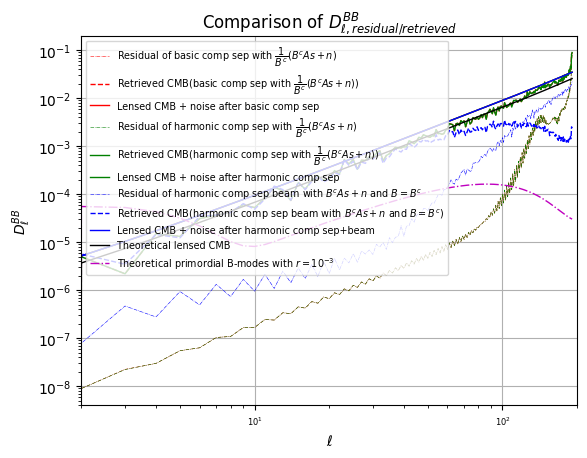

In [102]:
l_arr = np.arange(0,lmax+1,1)

py.figure(1)
ax1 = py.subplot(111)
ax1.tick_params('x', labelsize=6)

# # ##Basic comp sep on As+n
ax1.plot(l_arr,D_ell(Cl_res_CMB_basic[2]),'r-.',linewidth =.4,label = r'Residual of basic comp sep with $\dfrac{1}{B^c}(B^c As+n)$')
ax1.plot(l_arr,D_ell(Cl_ret_CMB_basic[2]),'r--',linewidth = 1,label = r'Retrieved CMB(basic comp sep with $\dfrac{1}{B^c}(B^c As+n)$)')
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_noise_basic),'r',linewidth =1,label = "Lensed CMB + noise after basic comp sep")


# ##Harmonic comp sep on As+n
ax1.plot(l_arr,D_ell(Cl_res_CMB_harmo_basic[1]),'g-.',linewidth =.4,label = r'Residual of harmonic comp sep with $\dfrac{1}{B^c}(B^c As+n)$')
ax1.plot(l_arr,D_ell(Cl_ret_CMB_harmo_basic[1]),'g-',linewidth = 1,label = r'Retrieved CMB(harmonic comp sep with $\dfrac{1}{B^c}(B^c As+n)$)')
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_noise_harmonic),'g',linewidth =1,label = "Lensed CMB + noise after harmonic comp sep")

# Harmonic_comp_sep beam with Identity beam on As+n
ax1.plot(l_arr,D_ell(Cl_res_CMB_harmo_beam[1]),'b-.',linewidth =.4,label = r'Residual of harmonic comp sep beam with $B^c As+n$ and $B=B^c$')
ax1.plot(l_arr,D_ell(Cl_ret_CMB_harmo_beam[1]),'b--',linewidth = 1,label = r'Retrieved CMB(harmonic comp sep beam with $B^c As+n$ and $B=B^c$)')
ax1.plot(l_arr,D_ell(cl_CMB_crop_th[2]+cl_noise_harmonic_beam),'b',linewidth =1,label = "Lensed CMB + noise after harmonic comp sep+beam")


## Diff harmo and harmo_beam
# ax1.plot(l_arr,np.abs(D_ell(Cl_res_CMB_harmo_beam[1]-Cl_res_CMB_harmo_basic[1])),'b-.',linewidth =.4,label = r'Residual difference')
# ax1.plot(l_arr,np.abs(D_ell(Cl_ret_CMB_harmo_beam[1]-Cl_ret_CMB_harmo_basic[1])),'b-',linewidth = .4,label = r'Retrieved CMB difference')



# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_noise_beam,'r--',linewidth =1, label = 'Noise')
ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*cl_CMB_crop_th[2],'k',linewidth =1,label = "Theoretical lensed CMB")
# ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*CL_CMB_smooth[2],'k--',linewidth =.4,label = "Beamed theoretical lensed CMB")

py.title('Comparison of $D_{\ell , residual/retrieved}^{BB}$ ')
         #with input $\dfrac{1}{B^c}(B^c As+n)$')


ax1.plot(l_arr,l_arr*(l_arr+1)/np.pi*0.001*cl_GW_crop[2],'m-.',linewidth =1,label = "Theoretical primordial B-modes with $r=10^{-3}$")


handles, labels = ax1.get_legend_handles_labels()
py.xlim(left = 2)
py.grid()
py.xlabel('$\ell$')
py.yscale("log")
py.xscale("log")
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')

py.ylabel('$D_{\ell}^{BB}$')
py.legend(handles,labels, loc = 'upper left', fontsize = 'x-small')
py.show()

In [103]:
print(np.subtract(C_BB_CMB_ren_l,cl_beam_ren))

NameError: name 'C_BB_CMB_ren_l' is not defined

# Cosmological parameters

In [ ]:
def cosmo_likelihood(r,C_l_obs,noise):
    if len(C_l_obs)!=lmax+1 or len(noise)!=lmax+1:
        raise Warning("Arrays should be of size "+str(lmax))
    
    C_lth =r*cl_GW_crop[2]+cl_CMB_crop_th[2]+noise
    sig = 0
    for l in range(2,lmax):
        sig+=(2*l+1)*(np.log(C_lth[l])+C_l_obs[l]/C_lth[l])
    return (sig)


In [ ]:
avg_cosmo_ren = cosmo_likelihood(r=0,C_l_obs=C_l_ret_ren_BB,noise=cl_beam_ren)
avg_cosmo_inv = cosmo_likelihood(r=0,C_l_obs=C_l_inv_BB,noise=cl_beam_inv)

print(avg_cosmo_ren)

In [ ]:
r_arr = np.logspace(-2.3,-2,100)
y_ren =np.array([cosmo_likelihood(r,C_l_obs=C_l_ret_ren_BB,noise=cl_beam_ren) for r in r_arr])
y_inv =np.array([cosmo_likelihood(r,C_l_obs=C_l_inv_BB,noise=cl_beam_inv) for r in r_arr])
y_inv0 = np.min(y_inv)

In [ ]:
fig,ax = py.subplots()

# ax.plot(r_arr,np.exp((avg_cosmo_ren-y_ren)/2),'r-.', label = 'result with '+r'$\frac{B^c}{B^{\nu}}$')
ax.plot(r_arr,np.exp((y_inv0-y_inv)/2),'b-.',label = 'result with '+r'$\frac{1}{B^{\nu}}$')



py.title('Likelihood (up to a constant) as function of tensor-to-scalar ratio')
handles, labels = ax.get_legend_handles_labels()
py.xlabel(r'$r$')
py.ylabel(r'$e^{\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')

# py.ylabel(r'$e^{-1+\frac{\langle ln \mathcal{L}_{par} \rangle}{\langle ln \mathcal{L}_{par}(r=0) \rangle}}$')
# py.yscale("log")
py.xscale("log")
# py.xlim(0,1e-3)
py.grid()
# py.ylim(-1,1)

        #  of the residuals with and without beam, with noise')
# Set the background color of the plot
# ax.set_facecolor('gray')

# Set the background color of the figure
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
# ax.title.set_color('white')
# fig.set_facecolor('gray')

py.legend(handles,labels, loc = 'best', fontsize = 'x-small')
py.show()